In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import accuracy_score

# READ FROM DATABASE

In [189]:
import psycopg2

In [190]:
# jdbc:postgresql://pg-graduate-delt.postgres.database.azure.com:5432/{your_database}?user=snartimaal&password={your_password}&sslmode=require
with psycopg2.connect(
    database='pgsql-graduate-gruppe3',
    user='snartimaal',
    password='#st44p44nu',
    host='pg-graduate-delt.postgres.database.azure.com'
) as conn:
    cur = conn.cursor()

In [191]:
try:
    cur = conn.cursor()
    sql_query = pd.read_sql_query("SELECT m.orgnummer, m.postnr, m.total_karakter, m.dato, m.tilsynsbesoektype, m.rutiner_og_ledelse_score, m.lokaler_og_utstyr_score, m.handtering_og_tilberedning_score, m.merking_og_sporbarhet_score, cs.antallansatte, cs.naeringskode1_kode \
                                  FROM mattilsynet m \
                                  JOIN orgnumber_junction oj ON m.orgnummer = oj.orgnumber \
                                  JOIN company_subunit cs ON oj.orgnumber = cs.organisasjonsnummer ;", 
                                  conn)
    df_test = pd.DataFrame(sql_query, columns=['postnr', 'dato', 'orgnummer', 'tilsynsbesoektype', 'total_karakter', 'naeringskode1_kode', 'antallansatte', 'rutiner_og_ledelse_score', 'lokaler_og_utstyr_score', 'handtering_og_tilberedning_score', 'merking_og_sporbarhet_score'])
except:
    conn.rollback()
    cur.close()

C:\Users\STM\AppData\Local\Temp\ipykernel_3804\1298957470.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_query = pd.read_sql_query("SELECT m.orgnummer, m.postnr, m.total_karakter, m.dato, m.tilsynsbesoektype, m.rutiner_og_ledelse_score, m.lokaler_og_utstyr_score, m.handtering_og_tilberedning_score, m.merking_og_sporbarhet_score, cs.antallansatte, cs.naeringskode1_kode \


In [192]:
df_test

,postnr,dato,orgnummer,tilsynsbesoektype,total_karakter,naeringskode1_kode,antallansatte,rutiner_og_ledelse_score,lokaler_og_utstyr_score,handtering_og_tilberedning_score,merking_og_sporbarhet_score
0,368,21112022,915937144,1,2,56.101,69.0,2.0,2,0.0,0.0
1,366,23012020,974999439,0,0,47.241,17.0,0.0,0,0.0,0.0
2,369,14092017,915893848,1,0,56.101,25.0,0.0,0,1.0,0.0
3,178,21082018,919228660,1,0,56.101,7.0,0.0,0,0.0,0.0
4,1081,26112018,912240770,1,0,55.101,80.0,1.0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5836,194,19012023,915465870,1,0,56.101,34.0,0.0,1,0.0,0.0
5837,190,01092022,996480550,0,1,56.102,4.0,0.0,1,0.0,0.0
5838,194,09092022,913536835,0,0,56.101,4.0,0.0,0,0.0,0.0
5839,179,12122022,929774671,0,1,56.101,21.0,0.0,1,1.0,0.0


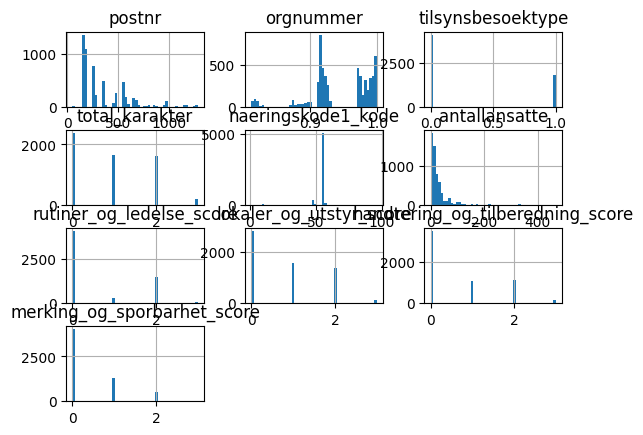

In [193]:
df_test.hist(bins=50)
plt.show()

# DATA PREP

In [194]:
# Endre dato til kun år ? De 4 siste sifrene 
dato = df_test['dato']
year_list = []

for i in dato.values:
    year_list.append(i[-4:])

df_test['dato'] = year_list

In [195]:
df_test

,postnr,dato,orgnummer,tilsynsbesoektype,total_karakter,naeringskode1_kode,antallansatte,rutiner_og_ledelse_score,lokaler_og_utstyr_score,handtering_og_tilberedning_score,merking_og_sporbarhet_score
0,368,2022,915937144,1,2,56.101,69.0,2.0,2,0.0,0.0
1,366,2020,974999439,0,0,47.241,17.0,0.0,0,0.0,0.0
2,369,2017,915893848,1,0,56.101,25.0,0.0,0,1.0,0.0
3,178,2018,919228660,1,0,56.101,7.0,0.0,0,0.0,0.0
4,1081,2018,912240770,1,0,55.101,80.0,1.0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5836,194,2023,915465870,1,0,56.101,34.0,0.0,1,0.0,0.0
5837,190,2022,996480550,0,1,56.102,4.0,0.0,1,0.0,0.0
5838,194,2022,913536835,0,0,56.101,4.0,0.0,0,0.0,0.0
5839,179,2022,929774671,0,1,56.101,21.0,0.0,1,1.0,0.0


In [196]:
ss_features = ['postnr', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'rutiner_og_ledelse_score', 'lokaler_og_utstyr_score', 'handtering_og_tilberedning_score', 'merking_og_sporbarhet_score']
ss_scaler = StandardScaler()
ss_scaler.fit(df_test[ss_features])
transformed_ss = ss_scaler.transform(df_test[ss_features])
df_test[ss_features] = transformed_ss

# TRAIN TEST SPLIT

In [197]:
features_test = df_test[['postnr', 'dato', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'rutiner_og_ledelse_score', 'lokaler_og_utstyr_score', 'handtering_og_tilberedning_score', 'merking_og_sporbarhet_score']]
X = np.c_[features_test]
y = np.c_[df_test['total_karakter']]

In [198]:
print(f'X len : {len(X)}')
print(f'y len : {len(y)}')

X len : 5841
y len : 5841


In [199]:
print(X.data.shape,
y.data.shape)

(5841, 10) (5841, 1)


In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [201]:
print(f'X_train len : {len(X_train)}')
print(f'X_test len : {len(X_test)}')
print(f'y_train len : {len(y_train)}')
print(f'y_test len : {len(y_test)}')

X_train len : 4672
X_test len : 1169
y_train len : 4672
y_test len : 1169


In [202]:
print(X_train.shape, y_train.shape)

(4672, 10) (4672, 1)


# Naiv score

In [203]:
pred_naiv = np.mean(y_train)
y_pred_naiv = np.full(y_test.shape, pred_naiv)
print(f'y_pred_naiv : {len(y_pred_naiv)}') # 1169

mse_naiv = mean_squared_error(y_test, y_pred_naiv)
print(f'Naiv MSE : {np.sqrt(mse_naiv)}') # 0.9147

mae_naiv = mean_absolute_error(y_test, y_pred_naiv)
print(f'Naiv MAE : {mae_naiv}') # 0.7819

y_pred_naiv : 1169
Naiv MSE : 0.9345249984725964
Naiv MAE : 0.7971608153555902


# XGBoost Model

In [204]:
regressor = xgb.XGBRegressor(
    early_stopping_rounds = 20,
    max_depth = 5
)

regressor.fit(X_train, y_train, eval_set = [(X_test, y_test)])
importance_check = pd.DataFrame(regressor.feature_importances_.reshape(1,-1), columns = [['postnr', 'dato', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'rutiner_og_ledelse_score', 'lokaler_og_utstyr_score', 'handtering_og_tilberedning_score', 'merking_og_sporbarhet_score']])


[0]	validation_0-rmse:0.72890
[1]	validation_0-rmse:0.51927
[2]	validation_0-rmse:0.37298
[3]	validation_0-rmse:0.27294
[4]	validation_0-rmse:0.20396
[5]	validation_0-rmse:0.15734
[6]	validation_0-rmse:0.12397
[7]	validation_0-rmse:0.10491
[8]	validation_0-rmse:0.09156
[9]	validation_0-rmse:0.07941
[10]	validation_0-rmse:0.07205
[11]	validation_0-rmse:0.06721
[12]	validation_0-rmse:0.05955
[13]	validation_0-rmse:0.05998
[14]	validation_0-rmse:0.05677
[15]	validation_0-rmse:0.05504
[16]	validation_0-rmse:0.05447
[17]	validation_0-rmse:0.05451
[18]	validation_0-rmse:0.05464
[19]	validation_0-rmse:0.05598
[20]	validation_0-rmse:0.05648
[21]	validation_0-rmse:0.05874
[22]	validation_0-rmse:0.06122
[23]	validation_0-rmse:0.06347
[24]	validation_0-rmse:0.06616
[25]	validation_0-rmse:0.06637
[26]	validation_0-rmse:0.06551
[27]	validation_0-rmse:0.06602
[28]	validation_0-rmse:0.06641
[29]	validation_0-rmse:0.06570
[30]	validation_0-rmse:0.06570
[31]	validation_0-rmse:0.06569
[32]	validation_0-

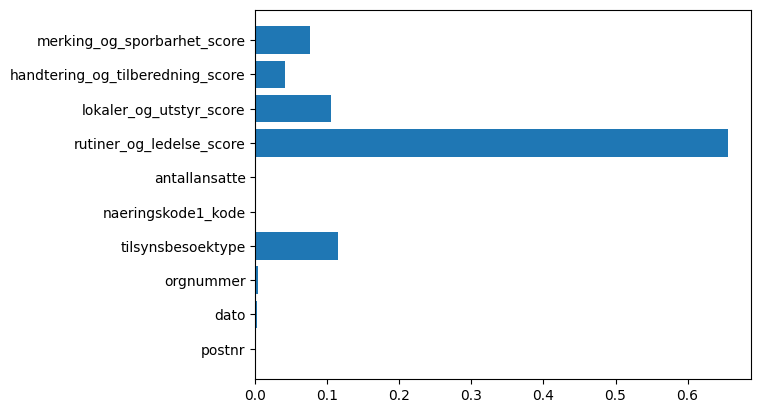

In [205]:
plt.barh(['postnr', 'dato', 'orgnummer', 'tilsynsbesoektype', 'naeringskode1_kode', 'antallansatte', 'rutiner_og_ledelse_score', 'lokaler_og_utstyr_score', 'handtering_og_tilberedning_score', 'merking_og_sporbarhet_score'], regressor.feature_importances_)
plt.show()

# Scoring xg

In [206]:
# Train xg
r2_train_xg = regressor.score(X_train, y_train)
print(f'Train R2 XG : {r2_train_xg}') # 6f 0.3071 / m.år 0.4545

y_pred_train_xg = regressor.predict(X_train)
mse_train_xg = mean_squared_error(y_train, y_pred_train_xg)
print(f'Train MSE XG : {np.sqrt(mse_train_xg)}') # 6f 0.7480 / m.år 0.6641

mae_train_xg = mean_absolute_error(y_train, y_pred_train_xg)
print(f'Train MAE XG : {mae_train_xg}') # 6f 0.5854 / m.år 0.5156

# Test xg
r2_test_xg = regressor.score(X_test, y_test)
print(f'Test R2 XG : {r2_test_xg}') # 6f 0.1754 / m.år 0.2766

y_pred_test_xg = regressor.predict(X_test)
mse_test_xg = mean_squared_error(y_test, y_pred_test_xg)
print(f'Test MSE XG : {np.sqrt(mse_test_xg)}') # 6f 0.8305 / m.år 0.7755

mae_test_xg = mean_absolute_error(y_test, y_pred_test_xg)
print(f'Train MAE XG : {mae_test_xg}') # 6f 0.6631 / m.år 0.6029

Train R2 XG : 0.9962631138901126
Train MSE XG : 0.0546261748412926
Train MAE XG : 0.020676378615163443
Test R2 XG : 0.9966024563094922
Test MSE XG : 0.05447191903187695
Train MAE XG : 0.021963292192086144


# Linear Regression Model

In [207]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_test, y_test)

## TRAIN

r2_train = lin_reg_model.score(X_train, y_train)
y_train_pred_linreg = lin_reg_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred_linreg)
mse_train = mean_squared_error(y_train, y_train_pred_linreg)
print(f'Train R2 : {r2_train}') # 0.1616 / 6f 0.17036 / m.år 0.1595
print(f'Train MAE : {mae_train}') # 0.6758 / 6f 0.6559 / m.år 0.6557
print(f'Train MSE : {np.sqrt(mse_train)}') # 0.8256 / 6f 0.8185 / m.år 0.8244

## TEST

r2_test = lin_reg_model.score(X_test, y_test)
y_test_pred_linreg = lin_reg_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred_linreg)
mse_test = mean_squared_error(y_test, y_test_pred_linreg)
print(f'Test R2 : {r2_test}') # 0.1802 / 6f 0.1664 / m.år 0.2152
print(f'Test MAE : {mae_test}') # 0.6662 / 6f 0.6802 / m.år 0.6399
print(f'Test MSE : {np.sqrt(mse_test)}') # 0.8164 / 6f 0.8351 / m.år 0.8077

Train R2 : 0.793737809148751
Train MAE : 0.3020514427068783
Train MSE : 0.4058407693863059
Test R2 : 0.8352113379121384
Test MAE : 0.2930261937687252
Test MSE : 0.37936198963897905


# Logistic Regression Model

C:\Users\STM\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train accuracy : 0.9375
Train Precision : 1.0
Train Recall : 0.9992542878448919


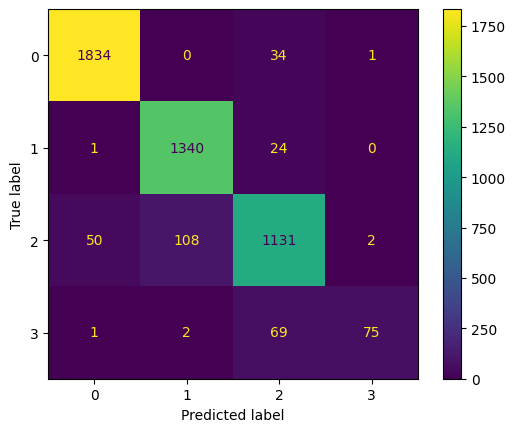

In [208]:
# y_train = y_train.reshape(-1)
log_reg_model = LogisticRegression(max_iter = 1000)
log_reg_model.fit(X_train, y_train)

y_pred_cm = log_reg_model.predict(X_train)
#y_train_pred_prod = log_reg_model.predict_proba(X_train)
#y_train_pred_prod_1 = y_train_pred_prod[:,1]
#y_train_pred = y_train_pred_prod_1 > 0.1

train_acc = accuracy_score(y_train, y_pred_cm)
print(f'Train accuracy : {train_acc}')

cm_train = confusion_matrix(y_train, y_pred_cm)

tn_train = cm_train[0,0]
fp_train = cm_train[0,1]
fn_train = cm_train[1,0]
tp_train = cm_train[1,1]

precision_train = tp_train/(tp_train+fp_train)
recall_train = tp_train/(tp_train+fn_train)
print(f'Train Precision : {precision_train}')
print(f'Train Recall : {recall_train}')

ConfusionMatrixDisplay(cm_train).plot()
plt.show()

# KNeighbors Regressor Model

In [165]:
model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train, y_train)

# KNN score
# Train
R2_train_knn = model_knn.score(X_train, y_train)
y_pred_train_knn = model_knn.predict(X_train)
mae_train_knn = mean_absolute_error(y_train, y_pred_train_knn)
mse_train_knn = mean_squared_error(y_train, y_pred_train_knn)
print(f'Knn Train Score:')
print(f'R2_train : {R2_train_knn}') # 0.3681
print(f'MAE train : {mae_train_knn}') # 0.5506
print(f'MSE train : {np.sqrt(mse_train_knn)}') # 0.7171

# Test
R2_test_knn = model_knn.score(X_test, y_test)
y_test_pred_knn = model_knn.predict(X_test)
mae_test_knn = mean_absolute_error(y_test, y_test_pred_knn)
mse_test_knn = mean_squared_error(y_test, y_test_pred_knn)
print(f'Knn Test Score:')
print(f'R2_test : {R2_test_knn}') # 0.1192
print(f'MAE test : {mae_test_knn}') # 0.6579
print(f'MSEtest : {np.sqrt(mse_test_knn)}') # 0.8453

Knn Train Score:
R2_train : 0.3681081070128853
MAE train : 0.5506421232876713
MSE train : 0.7171874766839761
Knn Test Score:
R2_test : 0.1192016552808981
MAE test : 0.6579982891360138
MSEtest : 0.8453364240367564
